## Modules
Needed to use non-Python functionalities already programmed by someone else.

In [1]:
# Used to cast the polygons into np.arrays and afterwards transpose them easily with the .T function
import numpy as np
import matplotlib.pyplot as plt    # to plot the counties
# Used to determine which part of the plot should be saved
from matplotlib.transforms import Bbox

# To add a colorbar to the plot of the matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Used to navigate the directories and check for files
import os
# backup directory of this file, because the working directory is changed to save files
cor_mx_by_pop_density_directory = os.getcwd()

## Get the Data
Read the file ["Readme.ipynb"](Readme.ipynb) or check out the files ["get_data.ipynb"](get_data.ipynb) and ["get_geographical_data_of_german_counties.ipynb"](get_geographical_data_of_german_counties.ipynb) for more information about the data collection.

In [2]:
os.chdir(".."), os.chdir("..")   # move two directories up
%run color_scheme.ipynb
os.chdir("collect_data")
%run get_data.ipynb
os.chdir(cor_mx_by_pop_density_directory)    # return to original directory

Polished county data from file is ready to go!
Polished covid19 data from file is ready to go!


## Control
Set variables to "True" to trigger the action described by the comment and the variable's name.

In [3]:
show_correlation_matrix_big = False

## Function to calculate the probability of correlations between two arrays

In [4]:
def sort_AdmUnitIDs_by_population_density():
    county_by_population_density = dict()
    for AdmUnitID, county in counties_geography.items():
        if county['population_density'] in county_by_population_density.keys():
            raise Exception("The population density " + str(county['population_density']) +
                            "seems to be relate to two counties")
        else:
            county_by_population_density[county['population_density']] = AdmUnitID
    pop_densitys = list(county_by_population_density.keys())
    pop_densitys.sort()
    return [county_by_population_density[e] for e in pop_densitys]

In [5]:
# AdmUnitIds = list(covid19.keys())
AdmUnitIds = sort_AdmUnitIDs_by_population_density()

In [12]:
def get_correlation_matrix(get_max_correlation_not_sum = True, max_shift = 50):
    correlation_matrix = [[0 for c2 in range(len(AdmUnitIds))]
                          for c1 in range(len(AdmUnitIds))]
    for AdmUnitId in AdmUnitIds:
        for second_AdmUnitId in AdmUnitIds:
            i1, i2 = (AdmUnitIds.index(AdmUnitId), AdmUnitIds.index(second_AdmUnitId))
            # if AdmUnitId1 == AdmUnitId2: continue
            if (correlation_matrix[i1][i2] != 0): continue    # Already set
            correlation = covid19[AdmUnitId]["correlation"][second_AdmUnitId]
            offset = max_shift + 1
            while get_max_correlation_not_sum and abs(offset) > max_shift:
                # get the shift with the highest correlation probability
                offset = non_county_specific_data[
                    "correlation_position_array2_to_array1"][np.argmax(correlation)]
                correlation[np.argmax(correlation)] = 0
            if not(get_max_correlation_not_sum):    # sum up all probabilities
                lc = len(correlation)//2
                if (len(correlation[:lc]) != len(correlation[lc+1:])):
                    raise Exception("Len(correlation) not correct)")
                if (len(correlation[lc-max_shift:lc]) !=
                    len(correlation[lc:lc+max_shift])):
                    raise Exception("Len(correlation) aslökdfjaslö")
                offset = (-sum(correlation[lc-max_shift:lc]) +
                          sum(correlation[lc:lc+max_shift]))
            correlation_matrix[i1][i2] = offset
            correlation_matrix[i2][i1] = -offset
    return correlation_matrix

In [13]:
correlation_matrizes = list()
for config in [( True, 50), (True, 30), (True, 14),
               (False, 50), (False, 30), (False, 14)]:
    correlation_matrizes.append(get_correlation_matrix(config[0], config[1]))

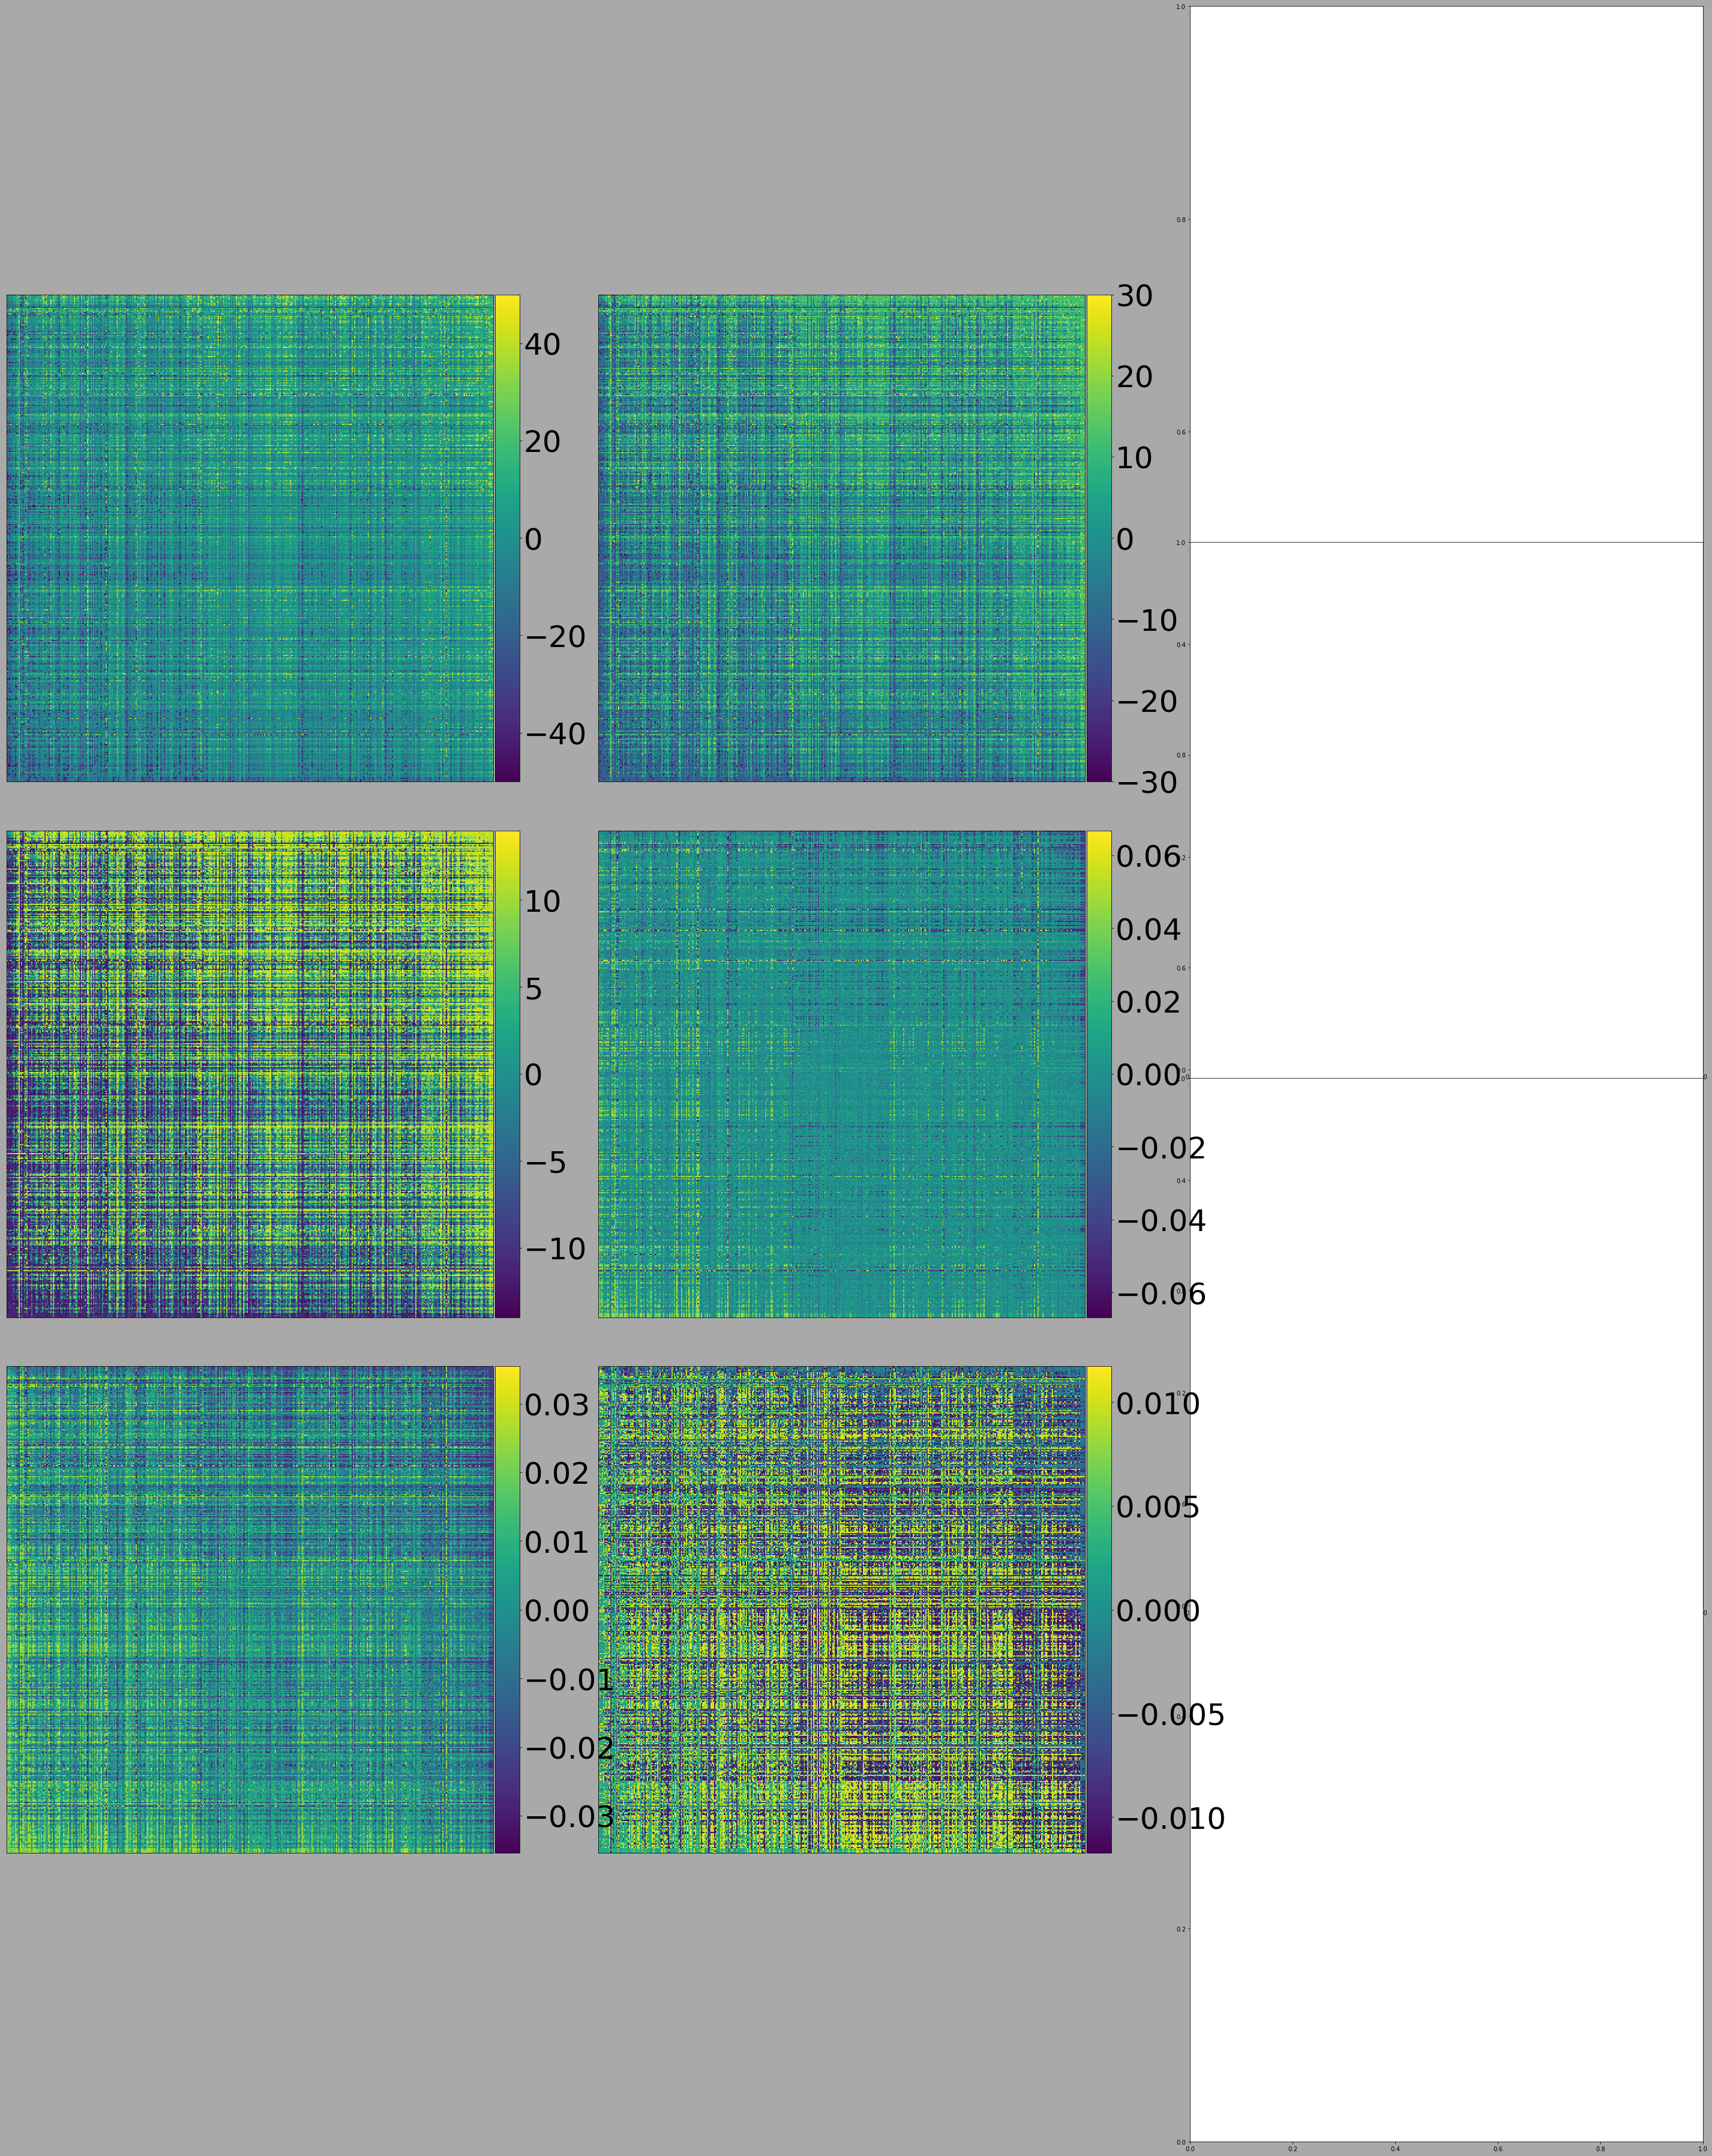

In [16]:
fig, ax = plt.subplots(3, 3, figsize = (40, 50), facecolor='darkgrey')
fig.tight_layout(h_pad=-90, w_pad=10)
i = 0
for correlation_matrix in correlation_matrizes:
    axis = ax[i//2][i%2]
    im1 = axis.matshow(correlation_matrix, interpolation='None')
    divider = make_axes_locatable(axis)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    axis.axes.get_xaxis().set_visible(False)
    axis.axes.get_yaxis().set_visible(False)
    cbar = fig.colorbar(im1, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=50)
    i+=1

In [17]:
if show_correlation_matrix_big:
    matfig = plt.figure(figsize=(20,20))
    plt.matshow(get_correlation_matrix(True, 100), fignum=matfig.number)
    plt.colorbar()

In [18]:
average_correlations = dict()
for row_index in range(len(correlation_matrix)):
    row = correlation_matrix[row_index]
    AdmUnitID = AdmUnitIds[row_index]
    # Because the row represents the shift of the second
    # county relative to the first, ralated to this row,
    # we need to take minus to get the average shift of the county
    # relative to all others
    average_correlations[AdmUnitID]=-(sum(row)/len(row))

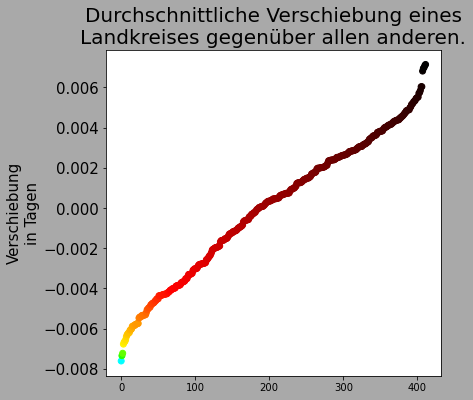

In [19]:
plt.figure(figsize=(6, 6), facecolor='darkgrey')    # enlarge plot
average_correlations_copy = list(average_correlations.values()).copy()
average_correlations_copy.sort()
# scale average_correlation_copy to calculate the colors
average_correlations_copy_scaled = [(c-average_correlations_copy[0])*
                                   (2000//average_correlations_copy[-1]) 
                                   for c in average_correlations_copy]

plt.title("Durchschnittliche Verschiebung eines\nLandkreises gegenüber allen anderen.",
         fontsize=20)
plt.ylabel("Verschiebung\nin Tagen", fontsize=15)
plt.yticks(fontsize=15)

colors = list()
for avg_correlation in average_correlations_copy_scaled:
    colors.append(color_scheme(avg_correlation, average_correlations_copy_scaled))
plt.scatter([i for i in range(len(average_correlations_copy))],
            average_correlations_copy, color=colors)
#plt.savefig("media/raw_pictures/incidences_sums_counties_distribution.png",
            #facecolor="darkgrey", bbox_inches=Bbox([[-0.7,0.4],[5.7,6]]))

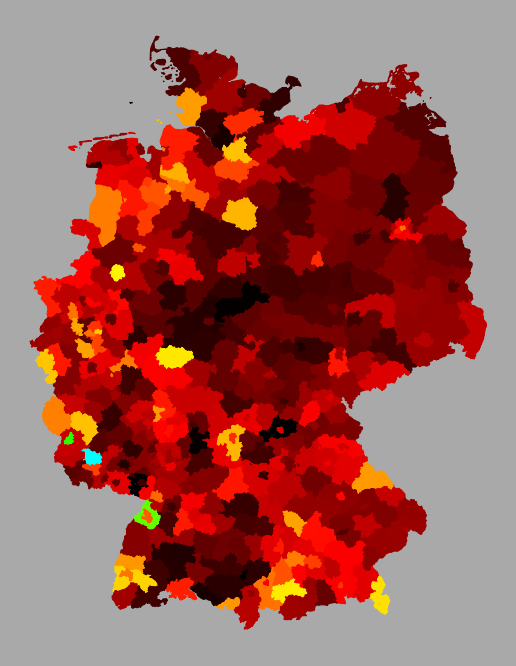

In [20]:
plt.figure(figsize=(9, 12), facecolor='darkgrey')    # enlarge plot
ax = plt.axes(frameon=False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_facecolor('darkgrey')
for AdmUnitId, correlation in average_correlations.items():
    scalled_correlation=((correlation-average_correlations_copy[0])*
                         (2000//average_correlations_copy[-1]))
    for polygon in counties_geography[AdmUnitId]['geometry']:
        x,y = np.array(polygon).T
        plt.fill(x, y,
                 color=color_scheme(scalled_correlation, average_correlations_copy_scaled))
#plt.savefig("media/raw_pictures/incidences_sums_counties.png",
            #facecolor="darkgrey", bbox_inches=Bbox([[1,1.5],[8,10.5]]))